# Trabajo Práctico Nº3

**Integrantes**:
- Santiago Belen
- Lucas Mendoza

**Objetivos**:
Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en ./tp3/images a partir del template ./tp3/template
1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen
coca_multi.png con el mismo témplate del item 1
1. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.
Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza
de la detección.

---


### Nota: 
Se decide contemplar las preguntas 1 y 2 implementando la pregunta 3 la cual nos permite responder todas las consultas en una sola ejecución. 

### Detalles de pre procesamiento
##### <u>Plantilla:</u>
Se carga la plantilla en escala de grises y se genera una versión invertida. Ambas versiones (invertida y no invertida) son luego recortadas en los bordes para mejorar el match. <u>Justificación:</u> El recorte de bordes facilita el match en aquellos logos presentes en botellas o latas al eliminar las zonas que no serán fácilmente visibles dada las características del contenedor. Por otro lado, el tener la posibilidad de buscar match con una plantilla invertida facilita la identificación del logo en casos inusuales como imagenes en blanco y negro. 
##### <u>Imagenes:</u> 
Se cargan las imagenes en escala de grises. 

### Detalles de procesamiento
Se setea un valor umbral de 0.43 para el metodo cv.TM_CCOEFF_NORMED. 
Se realiza la búsqueda de match en un espacio de múltiples tamaños de plantilla (np.linspace(0.1, 3.0, 250)), en caso de no registrarse match con la plantilla invertida, se intenta con la no invertida. <u>Justificación:</u> Tamaños bajos de plantilla (0.1) permitieron detectar pequeños logos, como el presente en la imagen coca_retro_2.png  (vaso en la mano de la mujer). Tamaños altos de plantilla (3.0) fueron efectivos para detectar logos cuando la imagen del logo era mucho más grande, como en COCA-COLA-LOGO.jpg. Número de pasos (250): este valor se eligió para optimizar los tiempos de ejecución sin comprometer significativamente los niveles de confianza.

### Conclusión
El presente algoritmo logra detectar todos los logos presentes en las imagenes propuestas, a excepción de 1 logo en la esquina inferior derecha de la imagen coca_multi.png. El mismo podría ser detectado si se optara por recortar un poco mas el borde derecho del template. 

Valor mínimo de confianza: 48.69% en imagen COCA-COLA-LOGO.jpg
Valor máximo de confianza: 83.67% en imagen coca_logo_1.png

Se aclara que pasos extra de pre procesamiento tanto en el template, como en las imagenes (gaussian blur, filtro bilateral, normalizado, binarizado, bordes, ect) no mejoraron las detecciones de forma constante en todas las imagenes por igual, y en algunos casos hasta eliminaban la detección completamente. 

In [51]:
# Importación de bibliotecas
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from imutils.object_detection import non_max_suppression
import glob

In [52]:
# Configuración de rutas y parámetros
ruta_template = "./resources/template/pattern.png"
ruta_imagenes = "./resources/images/"
rutas_imagenes = glob.glob(f'{ruta_imagenes}*')

# Umbral de confianza para la detección
umbral = 0.43

# Listas para almacenar imágenes y titulos
todas_las_imagenes = []
todos_los_titulos = []

In [53]:
# Mostrar imágenes en una cuadrícula
def mostrar_imagenes_en_cuadricula(titulos, imagenes, columnas=3):
    num_imagenes = len(imagenes)
    filas = (num_imagenes + columnas - 1) // columnas
    plt.figure(figsize=(15, 5 * filas))
    for i in range(num_imagenes):
        plt.subplot(filas, columnas, i + 1)
        if len(imagenes[i].shape) == 2:
            plt.imshow(imagenes[i], cmap='gray')
        else:
            plt.imshow(cv.cvtColor(imagenes[i], cv.COLOR_BGR2RGB))
        plt.title(titulos[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Detectar el template en una imagen
def detectar_template(imagen_gris, template, umbral=0.4):
    detecciones = []
    puntuaciones = []
    escalas = np.linspace(0.1, 3.0, 250)
    alto_template, ancho_template = template.shape

    for escala in escalas:
        ancho = int(ancho_template * escala)
        alto = int(alto_template * escala)

        if ancho <= 0 or alto <= 0 or ancho > imagen_gris.shape[1] or alto > imagen_gris.shape[0]:
            continue

        plantilla_redimensionada = cv.resize(template, (ancho, alto))
        ancho, alto = plantilla_redimensionada.shape[::-1]
        resultado = cv.matchTemplate(imagen_gris, plantilla_redimensionada, cv.TM_CCOEFF_NORMED)
        ubicaciones = np.where(resultado >= umbral)
        puntuaciones_escala = resultado[resultado >= umbral]

        for pt, puntuacion in zip(zip(*ubicaciones[::-1]), puntuaciones_escala):
            x, y = pt
            detecciones.append([x, y, ancho, alto])
            puntuaciones.append(float(puntuacion))

    return detecciones, puntuaciones

# Pre procesado template
def preprocesar_plantilla(plantilla):
    if plantilla is None:
        print("Error: No se pudo cargar la plantilla.")
        exit()
    else:
        print("Plantilla cargada correctamente.\n")
        
        plantilla_gris = cv.cvtColor(plantilla, cv.COLOR_BGR2GRAY)
        plantilla_invertida = cv.bitwise_not(plantilla_gris)
        alto, ancho = plantilla_invertida.shape
        plantilla_invertida_recortada = plantilla_invertida[30 : alto - 30, 80 : ancho - 80]
        plantilla_recortada = plantilla_gris[30 : alto - 30, 80 : ancho - 80]
        return plantilla_invertida_recortada, plantilla_recortada

# Pre procesado imagenes
def preprocesar_imagen(imagen):
    return cv.cvtColor(imagen, cv.COLOR_BGR2GRAY)

# Agregar imágenes procesadas para visualización
def agregar_imagenes_a_mostrar(imagen_con_detecciones, imagen, imagen_procesada, ruta_imagen):
    imagen_original = imagen.copy()
    imagenes_a_mostrar = [imagen_original]
    titulos = [f'Imagen Original - {ruta_imagen}']

    imagenes_a_mostrar.append(cv.cvtColor(imagen_procesada, cv.COLOR_GRAY2BGR))
    titulos.append('Imagen Preprocesada (Escala de Grises)')
    
    imagenes_a_mostrar.append(imagen_con_detecciones)
    titulos.append('Detecciones')
    
    return imagenes_a_mostrar, titulos

# Calcular confianza 
def calcular_confianza(puntuaciones, indices):
    if not indices.any():
        return "0%" 
    
    puntuaciones_seleccionadas = [puntuaciones[i] for i in indices]
    confianza = sum(puntuaciones_seleccionadas) / len(puntuaciones_seleccionadas)
    
    return f"{confianza * 100:.2f}%"

# Procesamiento de detecciones y puntuaciones
def procesar_detecciones_puntuaciones(imagen, imagen_procesada, detecciones, puntuaciones, ruta_imagen, todas_las_imagenes, todos_los_titulos):
    numDetecciones = len(detecciones)
    
    if numDetecciones > 0:
        detecciones = np.array(detecciones).tolist()
        puntuaciones = np.array(puntuaciones).tolist()
        indices = cv.dnn.NMSBoxes(detecciones, puntuaciones, umbral, 0.2)
        indices = np.array(indices).flatten()
        imagen_con_detecciones = imagen.copy()

        for i in indices:
            x, y, w, h = detecciones[i]
            cv.rectangle(imagen_con_detecciones, (x, y), (x + w, y + h), (0, 255, 0), 3)

        confianza = calcular_confianza(puntuaciones, indices)
        print(f"Se encontraron {len(indices)} coincidencias con una confianza de {confianza}.\n")
        
        imagenes_a_mostrar, titulos = agregar_imagenes_a_mostrar(imagen_con_detecciones, imagen, imagen_procesada, ruta_imagen)
        todas_las_imagenes.extend(imagenes_a_mostrar)
        todos_los_titulos.extend(titulos)
    else:
        print(f"No se encontraron coincidencias en con ninguna plantilla.\n")

# Detectar logo en imagenes
def detectar_imagenes_con_template():
    plantilla = cv.imread(ruta_template)
    plantilla_invertida_recortada, plantilla_recortada = preprocesar_plantilla(plantilla)

    for ruta_imagen in rutas_imagenes:
        print(f"{ruta_imagen}")
        imagen = cv.imread(ruta_imagen)
     
        if imagen is None:
            print(f"Error: No se pudo cargar la imagen.")
            continue
        else:
            print(f"Imagen cargada correctamente.")
        
        imagen_procesada = preprocesar_imagen(imagen)
        detecciones, puntuaciones = detectar_template(imagen_procesada, plantilla_invertida_recortada, umbral)
        
        if len(detecciones) == 0:
            print(f"No se encontraron coincidencias con plantilla invertida para la imagen. Intentando con plantilla no invertida...")
            detecciones, puntuaciones = detectar_template(imagen_procesada, plantilla_recortada, umbral)

        procesar_detecciones_puntuaciones(imagen, imagen_procesada, detecciones, puntuaciones, ruta_imagen, todas_las_imagenes, todos_los_titulos)


Plantilla cargada correctamente.

./resources/images\COCA-COLA-LOGO.jpg
Imagen cargada correctamente.
Se encontraron 1 coincidencias con una confianza de 48.69%.

./resources/images\coca_logo_1.png
Imagen cargada correctamente.
Se encontraron 1 coincidencias con una confianza de 83.67%.

./resources/images\coca_logo_2.png
Imagen cargada correctamente.
Se encontraron 1 coincidencias con una confianza de 62.35%.

./resources/images\coca_multi.png
Imagen cargada correctamente.
Se encontraron 18 coincidencias con una confianza de 65.94%.

./resources/images\coca_retro_1.png
Imagen cargada correctamente.
No se encontraron coincidencias con plantilla invertida para la imagen. Intentando con plantilla no invertida...
Se encontraron 1 coincidencias con una confianza de 64.47%.

./resources/images\coca_retro_2.png
Imagen cargada correctamente.
Se encontraron 2 coincidencias con una confianza de 55.94%.

./resources/images\logo_1.png
Imagen cargada correctamente.
Se encontraron 1 coincidencias c

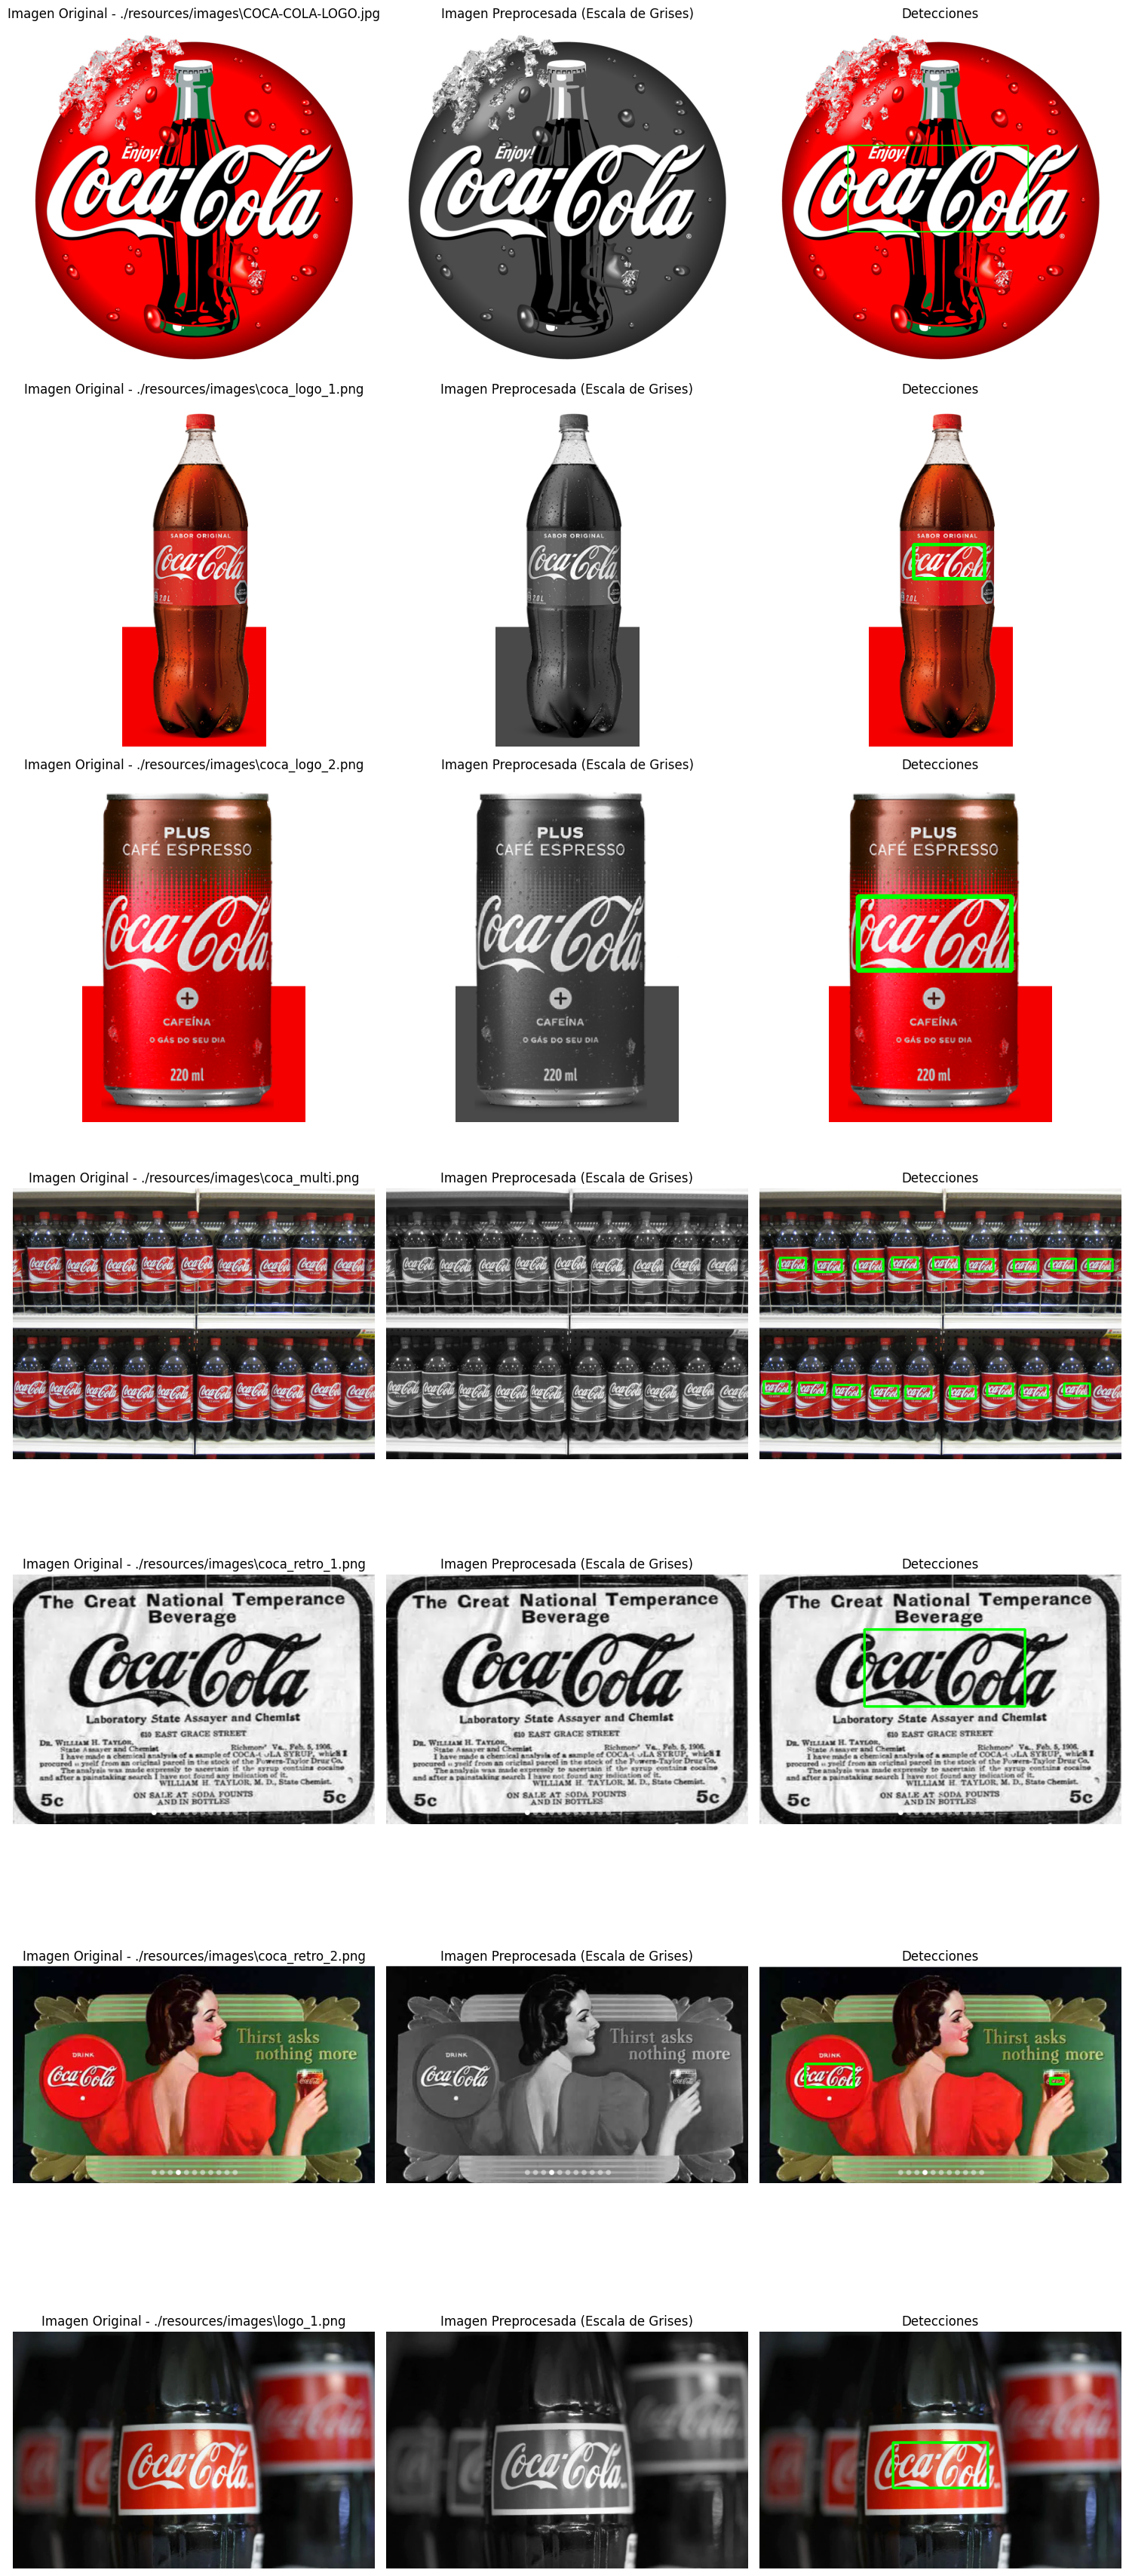

In [54]:
# Ejecutar script principal
detectar_imagenes_con_template()
mostrar_imagenes_en_cuadricula(todos_los_titulos, todas_las_imagenes)   